# The Power of Multitask Learning

A simple demonstration of the power of multi-task learning (MTL) compared to single-task learning (STL) approaches.

---

## Navigation

1. [Get Data](#Get-Data)
1. [Preprocessing](#Preprocessing)
1. [Modeling](#Modeling)
1. [Visualizations](#Visualizations)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

## Get Data

We use the [Chicago Taxicabs dataset](https://www.kaggle.com/chicago/chicago-taxi-trips-bq) which includes taxi trips from 2013 to mid. 2017, reported to the City of Chicago. </br>This dataset is publicly available for anyone to use under the following terms provided by the Dataset Source - https://data.cityofchicago.org.

In [4]:
import bq_helper
from bq_helper import BigQueryHelper

# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
chicago_taxi = bq_helper.BigQueryHelper(
    active_project="bigquery-public-data",
    dataset_name="chicago_taxi_trips"
)

In [5]:
companies = (
    'Blue Ribbon Taxi Association Inc.', 
    'Choice Taxi Association', 
    'Dispatch Taxi Affiliation',
    'Northwest Management LLC'
)
end_date = '2017-01-01'

qry = \
f"""
SELECT EXTRACT(date FROM trip_start_timestamp) AS ds
       ,company as task
       ,COUNT(1) AS num_rides
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 1=1
    AND company in {companies}
    AND EXTRACT(date FROM trip_start_timestamp) <= '{end_date}'
GROUP BY 1,2
ORDER BY 2,1        
"""

data = chicago_taxi.query_to_pandas_safe(qry, max_gb_scanned=20)
data.ds = pd.to_datetime(data.ds)
data.head()

,ds,task,num_rides
0,2013-01-01,Blue Ribbon Taxi Association Inc.,4623
1,2013-01-02,Blue Ribbon Taxi Association Inc.,2632
2,2013-01-03,Blue Ribbon Taxi Association Inc.,2806
3,2013-01-04,Blue Ribbon Taxi Association Inc.,3463
4,2013-01-05,Blue Ribbon Taxi Association Inc.,3558


In [6]:
def plot_tasks(data, y='num_rides'):
    fig, ax = plt.subplots(figsize=(15, 8))

    # unique tasks
    tasks = data.task.unique()
    n_tasks = len(tasks)
    
    # color map
    cmap = plt.get_cmap('magma', n_tasks+2)
    ax.set_prop_cycle(color=cmap.colors[range(1, n_tasks+1)])

    # plot
    for i, task in enumerate(tasks):
        # curr task
        task_data = data.loc[data.task == task].copy()

        ax.plot_date(
            task_data.ds, 
            task_data[y], 
            '-', 
            alpha=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig

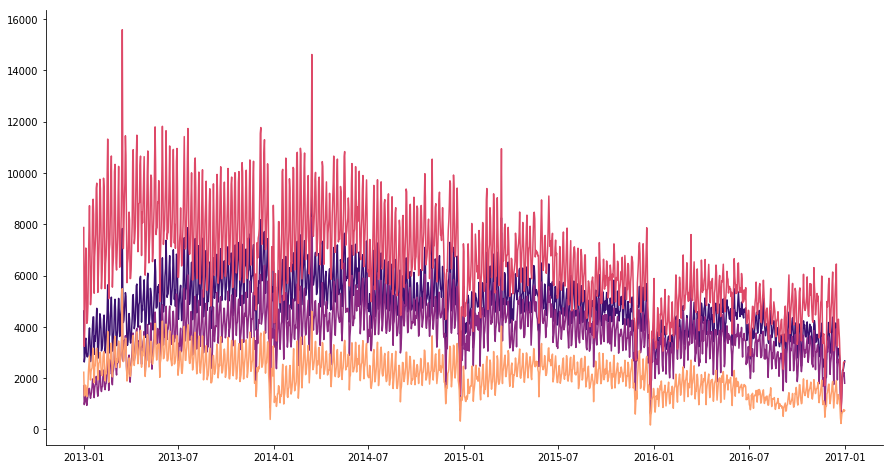

In [7]:
fig = plot_tasks(data)

## Preprocessing

### Scaling

   - Take $\log$
   - Divide by the maximal response value

In [8]:
data.sort_values(['task', 'ds'], inplace=True)

data = data.assign(
    scaled_num_rides = data.groupby('task').num_rides.apply(
        lambda x : np.log(x) / np.log(x).max()
    )
)

In [9]:
# Y df
Y_df = data.pivot_table(
    index='ds', 
    columns='task', 
    values='scaled_num_rides'
)

# to matrix
Y = Y_df.values
Y.shape

(1462, 4)

Let's look at the scaled data:

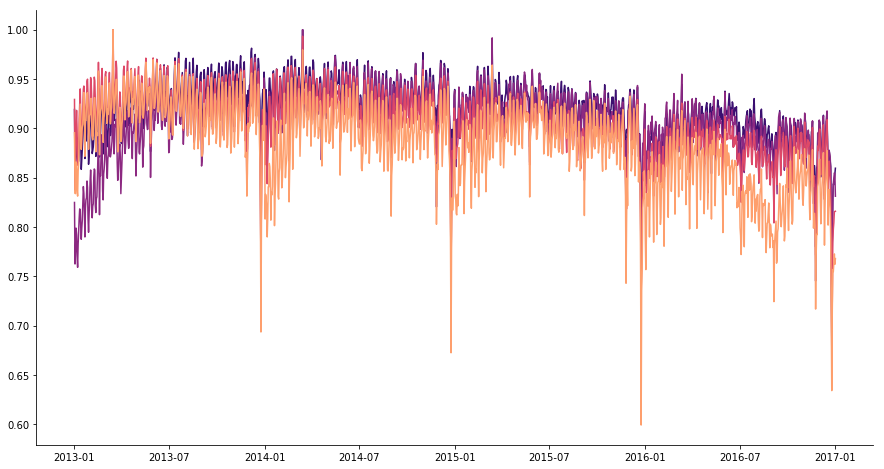

In [10]:
fig = plot_tasks(data, 'scaled_num_rides')
fig.savefig("../images/mtl-scaled-w-axes.png")

### $X$ Matrix

We utilize the Fourier series to model our data. For details, see:
1. [Sean J. Taylor, Benjamin Letham (2018) Forecasting at scale. The American Statistician 72(1):37-45](https://peerj.com/preprints/3190.pdf).
1. Harvey, A. C. & Shephard, N. (1993), Structural time series models, in G. Maddala, C. Rao
& H. Vinod, eds, ‘Handbook of Statistics’, Vol. 11, Elsevier, chapter 10, pp. 261–302.

Also, you can use the awesome [Prophet](https://github.com/facebook/prophet) package by Facebook.

In [11]:
# From: https://github.com/facebook/prophet/blob/master/python/fbprophet/forecaster.py#L373
epoch = pd.datetime(2010, 1, 1)

def fourier_series(dates, period, series_order, epoch=epoch):
        # convert to days since epoch
        t = (dates - epoch).dt.days
        
        return np.column_stack(
            [
                fun((2.0 * (i + 1) * np.pi * t / period))
                for i in range(series_order)
                for fun in (np.sin, np.cos)
            ]
        )

In [12]:
dates = data.ds.sort_values().drop_duplicates()

# changepoints matrix (for piecewise linear trend)
n_changepoints = 30
t = (dates - epoch).dt.days
        
cp = [
    (t.size // n_changepoints) * x 
    for x in range(n_changepoints)
]

X_cp = np.zeros((t.shape[0], n_changepoints))
t_scale = t / t.max()

for i, cpoint in enumerate(cp):
    X_cp[cpoint:, i] = t_scale[cpoint:]

In [13]:
X_seasonality = np.concatenate(
    [
        fourier_series(dates, period, series_order=10) 
        for period in [7, 365.25]
    ], axis=1
)

In [14]:
X = np.concatenate((X_seasonality, X_cp), axis=1)

In [15]:
X.shape

(1462, 70)

## Modeling

   - Single task lasso
   - Group lasso

In [16]:
class stlLasso():
    """
    Simple implementation of STL Lasso
    """
    def __init__(self, **kwargs):
        self.params = kwargs
        self.models = None
        
    def fit(self, X, Y):
        self.models = [
            LassoCV(**self.params).fit(X, Y[:,i]) 
            for i in range(Y.shape[1])
        ]
        return self
    
    def predict(self, X):
        return np.column_stack(
            [
                model.predict(X) 
                for model in self.models
            ]
        )

We will measure performance with MSE, using Simulated Historical Forecasts (SHF) for producing $K$ forecasts at various cutoff points in the history ([Sean J. Taylor, Benjamin Letham (2018) Forecasting at scale. The American Statistician 72(1):37-45](https://peerj.com/preprints/3190.pdf)).

In [17]:
n_test = 7
train_pct = .85
train_size = np.int(Y_df.shape[0] * train_pct)

cutoffs = np.arange(train_size, Y_df.shape[0], n_test)
len(cutoffs)

32

In [18]:
def evaluate(loss = mean_squared_error):
    res = []
    stl_preds = []
    mtl_preds = []
    
    for i, cutoff in enumerate(cutoffs):
        print(f'\rRunning cutoff {i+1} out of {len(cutoffs)}.', end='')
        
        # MTL
        m = MultiTaskLassoCV(normalize=True, max_iter=10000).fit(X[:cutoff,], Y[:cutoff,])
        Y_pred_mtl = m.predict(X[cutoff:cutoff+n_test])
        
        # STL
        sl = stlLasso(normalize=True, max_iter=10000)
        sl.fit(X[:cutoff,], Y[:cutoff,])
        Y_pred_stl = sl.predict(X[cutoff:cutoff+n_test])
        
        # results
        res.append(
            {
                'mtl_error':loss(Y[cutoff:cutoff+n_test], Y_pred_mtl),
                'stl_error':loss(Y[cutoff:cutoff+n_test], Y_pred_stl)
            }
        )
        
        stl_preds.append(Y_pred_stl)
        mtl_preds.append(Y_pred_mtl)
        
    return res, stl_preds, mtl_preds

In [31]:
res, stl_preds, mtl_preds = evaluate()

Running cutoff 32 out of 32.

In [32]:
print(f'MSE improvement {pd.DataFrame(res).mean().pct_change().values[1]*100:.2f}%')

MSE improvement 2.24%


## Visualization

Visualization for blog post.

In [19]:
from celluloid import Camera

### TS

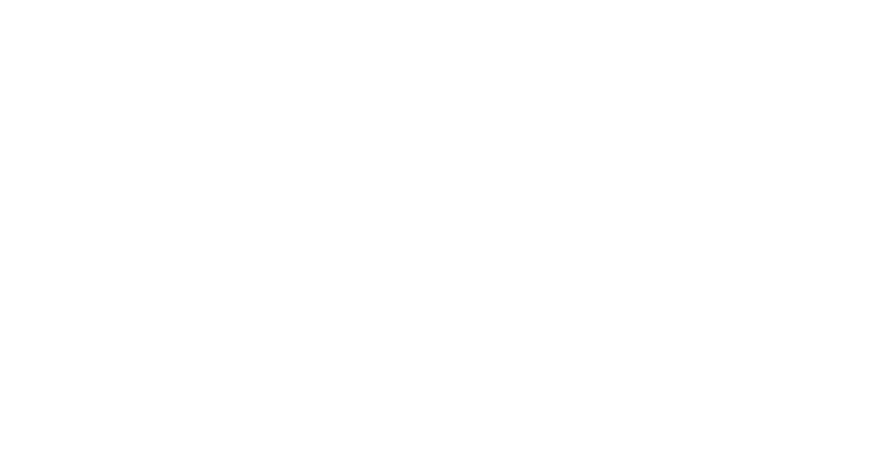

In [30]:
fig, ax = plt.subplots(figsize=(15, 8))

camera = Camera(fig)

# unique tasks
tasks = data.task.unique()
n_tasks = len(tasks)

# color map
cmap = plt.get_cmap('magma', n_tasks+2)
ax.set_prop_cycle(color=cmap.colors[range(1, n_tasks+1)])

# plot
for i, task in enumerate(tasks):
    # curr task
    task_data = data.loc[data.task == task].copy()

    plt.plot_date(
        task_data.ds, 
        task_data.scaled_num_rides, 
        '-', 
        alpha=1.
    )
    plt.axis('off')
    camera.snap()

animation = camera.animate()
animation.save('../images/mtl-ts.gif', writer = 'imagemagick', fps=1)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))

# camera = Camera(fig)

# # unique tasks
# tasks = data.task.unique()
# n_tasks = len(tasks)

# # color map
# cmap = plt.get_cmap('magma', n_tasks+2)
# #ax.set_prop_cycle(color=cmap.colors[range(1, n_tasks+1)])

# # plot
# for j in range(1, len(tasks)+1):
#     # color map
#     ax.set_prop_cycle(color=cmap.colors[range(1, 1+j)])
    
#     for i, task in enumerate(tasks[:j]):    
#         # curr task
#         task_data = data.loc[data.task == task].copy()

#         ax.plot_date(
#             task_data.ds, 
#             task_data.scaled_num_rides, 
#             '-', 
#             alpha=1.
#         )
#         ax.axis('off')
        
#     camera.snap()

# animation = camera.animate()
# animation.save('../images/mtl-ts-add.gif', writer = 'imagemagick', fps=1)

### Sparsity Structure

In [156]:
from matplotlib.colors import ListedColormap

In [212]:
mtl_mat = MultiTaskLassoCV(normalize=True, max_iter=10000).fit(X[:500], Y[:500]).coef_
stl = stlLasso(normalize=True, max_iter=10000).fit(X[:500], Y[:500])
stl_mat = np.stack([mod.coef_ for mod in stl.models])

In [213]:
# colors
cmap = plt.get_cmap('magma', 256)
newcolors = cmap([.55, .95])
newcolors = ListedColormap(newcolors)

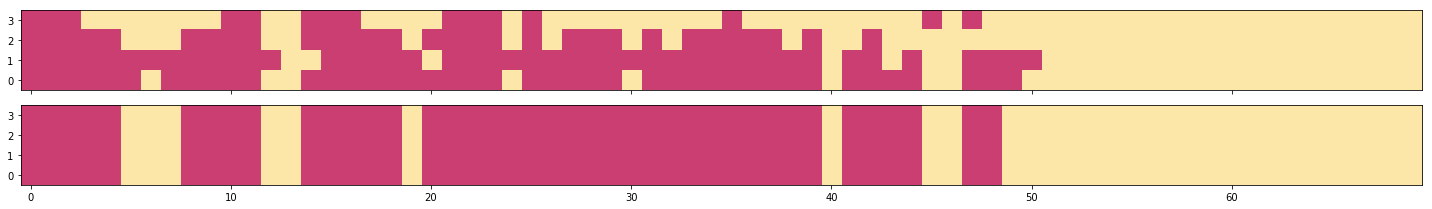

In [214]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 3), sharex=True, sharey=True)
matplot = ax1.imshow(np.where((stl_mat == 0), 1., .0), origin='lower', cmap=newcolors)
matplot = ax2.imshow(np.where((mtl_mat == 0), 1., .0), origin='lower', cmap=newcolors)
fig.tight_layout();

In [261]:
fig.savefig('../images/sparsity_structure.png')

### SHF

In [33]:
to_plot = pd.DataFrame(
    np.concatenate(stl_preds), 
    index=Y_df.iloc[train_size:].index,
    columns=Y_df.columns
)

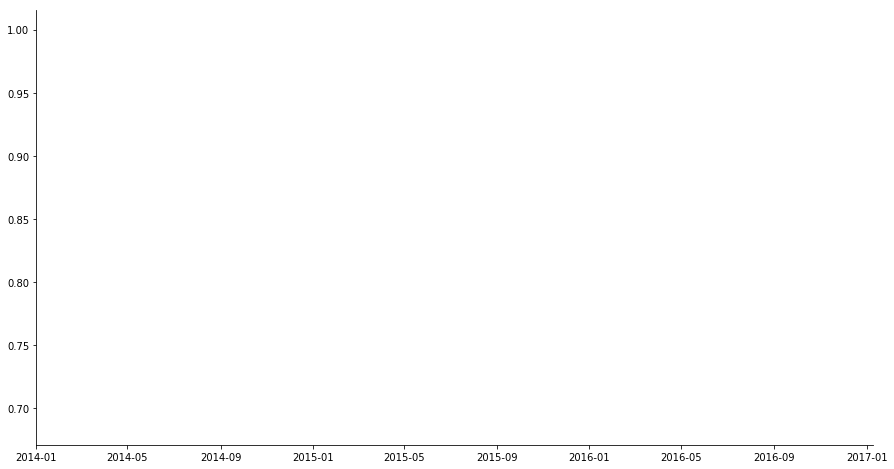

In [72]:
fig, ax = plt.subplots(figsize=(15, 8))

# axes
ax.set_xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2017-01-10'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

camera = Camera(fig)

# color map
cmap = plt.get_cmap('magma', (len(cutoffs)+1))

# task
task = 'Dispatch Taxi Affiliation'

for n_lines, i in enumerate(range(0, len(cutoffs)*7, 7)):
    plt.axvline(Y_df.iloc[train_size:].index[i], linestyle='--', c='k')
    
    # colors
    ax.set_prop_cycle(color=cmap.colors[:(n_lines+2)])
    
    # full ts
    ax.plot_date(Y_df.index, Y_df[task], '-', alpha=.5)
    
    for j in range(0, i+7, 7):    
        # shf
        ax.plot_date(
            to_plot.index[j:j+7], 
            to_plot[task].values[j:j+7], 
            '-'
        )
    
    camera.snap()

animation = camera.animate()
animation.save('../images/mtl-shf-moving-hline.gif', writer = 'imagemagick', fps=3)